# Imports

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import sys
sys.path.append("..")

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model.llm import LLM
from model.transformer import CosinePositionalEncoding, RMSNorm, SwiGLU, SelfAttention, MultiHeadAttention, FeedForward, TransformerBlock

# Model

In [31]:
bs, seq_len, dim_emb = 64, 32, 128
x = torch.randn((bs, seq_len, dim_emb))

## Check RMSNorm

In [97]:
rms_norm = RMSNorm(dim_emb)

with torch.no_grad():
    y = rms_norm(x)

print(f"{y.shape=}")

rms = torch.norm(x, dim=-1, keepdim=True) * (dim_emb**-0.5)
torch.allclose(x / rms, y)

y.shape=torch.Size([64, 128, 512])


True

## SwiGLU

In [36]:
swiglu = SwiGLU(dim_emb)

with torch.no_grad():
    y = swiglu(x)
    
print(y.shape)

torch.Size([64, 32, 128])


## Check positional encoding

y.shape=torch.Size([64, 128, 512])


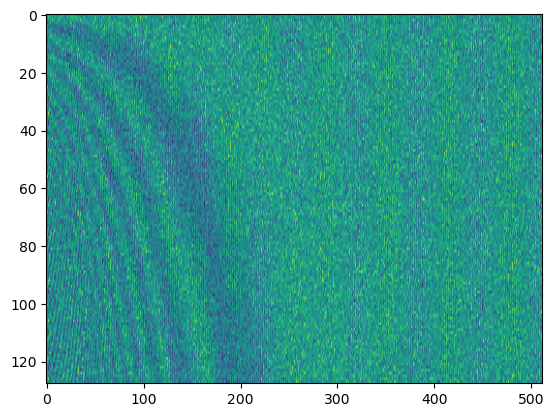

In [96]:
pos_encoding = CosinePositionalEncoding(seq_len, dim_emb)

with torch.no_grad():
    y= pos_encoding(x)

print(f"{y.shape=}")

plt.imshow(y[0, ...], aspect="auto")

## Check self attention

SelfAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)


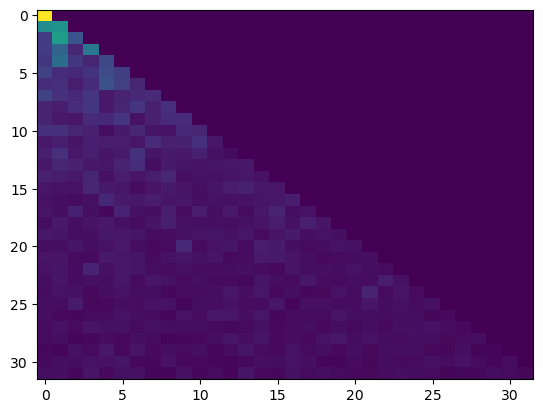

In [14]:
self_attn = SelfAttention(seq_len, dim_emb, causal=True)

print(self_attn)

with torch.no_grad():
    y, attn_scores = self_attn(x, return_scores=True)

plt.imshow(attn_scores[0, ...], aspect="auto")

SelfAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)


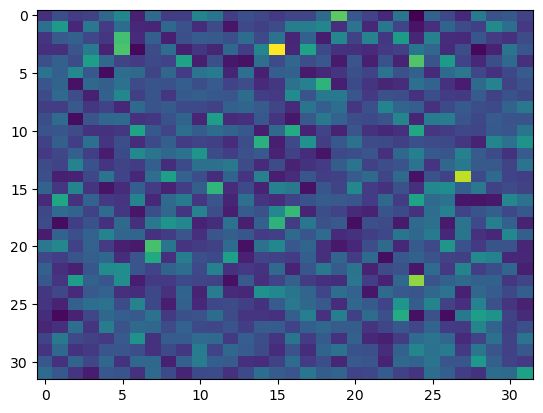

In [19]:
self_attn = SelfAttention(seq_len, dim_emb, causal=False)

print(self_attn)

with torch.no_grad():
    y, attn_scores = self_attn(x, return_scores=True)

plt.imshow(attn_scores[0, ...], aspect="auto")

## Check multihead attention

MultiHeadAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)
torch.Size([64, 32, 128])
torch.Size([64, 2, 32, 32])


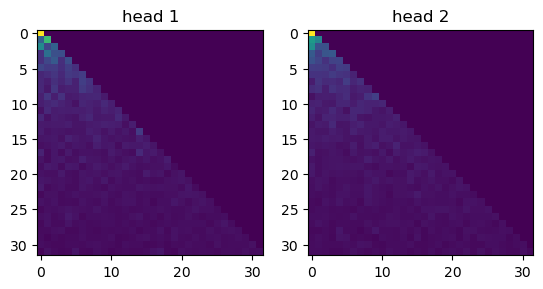

In [10]:
mha = MultiHeadAttention(seq_len, num_heads=2, dim_emb=dim_emb, causal=True)

print(mha)

with torch.no_grad():
    y, attn_scores = mha(x, return_scores=True)


print(y.shape)
print(attn_scores.shape)

fig, axes = plt.subplots(1, mha.num_heads)

for h in range(mha.num_heads):
    axes[h].imshow(attn_scores[0, h, ...], aspect="equal")
    axes[h].set_title(f"head {h+1}")

# Check feedforward

In [42]:
ffd = FeedForward(dim_emb, dim_emb, num_hidden=2)

print(ffd)

with torch.no_grad():
    y = ffd(x)

print(x.shape)
print(y.shape)

FeedForward(
  (_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): RMSNorm()
    (2): SwiGLU(
      (linear): Linear(in_features=128, out_features=256, bias=True)
    )
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
)
torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


## Transformer block

In [65]:
transformer = TransformerBlock(seq_len, dim_emb, attn_num_heads=2, attn_causal=True)

print(transformer)

with torch.no_grad():
    y = transformer(x)

print(x.shape)
print(y.shape)

TransformerBlock(
  (pos_encoding): CosinePositionalEncoding()
  (multihead_attn): MultiHeadAttention(
    (projection_query): Linear(in_features=128, out_features=128, bias=False)
    (projection_key): Linear(in_features=128, out_features=128, bias=False)
    (projection_value): Linear(in_features=128, out_features=128, bias=False)
    (projection_out): Linear(in_features=128, out_features=128, bias=False)
  )
  (feed_forward): FeedForward(
    (_layers): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): RMSNorm()
      (2): SwiGLU(
        (linear): Linear(in_features=128, out_features=256, bias=True)
      )
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (norm_1): RMSNorm()
  (norm_2): RMSNorm()
)
torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


## LLM

In [68]:
vocab_size = 1000
probs = torch.repeat_interleave(torch.Tensor([1 / vocab_size] * vocab_size).unsqueeze(0), 64, dim=0)
sequences = torch.multinomial(input=probs, num_samples=seq_len, replacement=True)

llm = LLM(vocab_size=vocab_size, seq_len=seq_len, dim_emb=dim_emb, num_layers=2, attn_num_heads=2, attn_causal=True)

print(llm)

with torch.no_grad():
    y = llm(sequences)

print(x.shape)
print(y.shape)

LLM(
  (token_embedding): Embedding(1000, 128)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=128, out_features=128, bias=False)
        (projection_key): Linear(in_features=128, out_features=128, bias=False)
        (projection_value): Linear(in_features=128, out_features=128, bias=False)
        (projection_out): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): RMSNorm()
          (2): SwiGLU(
            (linear): Linear(in_features=128, out_features=256, bias=True)
          )
          (3): Dropout(p=0.0, inplace=False)
          (4): Linear(in_features=128, out_features=128, bi